# Notebook pre steps

In [1]:
#@title Installations

# ALWAYS SAVE YOUR OWN COPY OF THIS NOTEBOOK: File > Save a copy in Drive
# IF DANISH MENU DO: Hjælp > Engelsk version

# To clear output do: Edit > Clear all outputs

## Useful shortscuts
# Run current cell: Cmd+Enter
# Run current cell and goto next: Shift+Enter
# Run selection (or line if no selection): Cmd+Shift+Enter

# install missing packages
!pip install dfply

from dfply import *
from plotnine import *
import numpy as np  # RNG and vector ops
import pandas as pd  # tabular outputs
from IPython.display import Markdown
# import json
# from pathlib import Path

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.4/612.4 kB 8.8 MB/s eta 0:00:00


In [2]:
#@title MDP class

import random
from collections import defaultdict
import numpy as np
import pandas as pd
import json
from pathlib import Path

class MDP:
    """
    A class representing a Markov Decision Process (MDP) using defaultdict structures.

    This implementation includes state management, action specification, transition
    probabilities, rewards, policies, and iterative algorithms for policy and value iteration.
    """

    def __init__(self):
        """
        Initializes an empty MDP with model and state values.
        """
        self.model = defaultdict(lambda: {"pi": None, "actions": defaultdict(dict)})
        self.v = defaultdict(float)

    def add_state_space(self, states):
        """
        Adds states to the MDP.

        Args:
            states (list): List of state identifiers (strings or convertible to strings).
        """
        for state in states:
            _ = self.model[str(state)]
        self.set_state_value()

    def add_action_space(self, state_str, actions):
        """
        Adds actions to a given state. Note you have to update the action
        afterwards using `add_action`.

        Args:
            state_str (str): The state identifier.
            actions (list): List of action identifiers.
        """
        if not isinstance(state_str, str):
            raise ValueError("State is not a sting!")
        if isinstance(actions, str):
            # If it's a string, put it in a list to treat it as a single item
            actions = [actions]
        for action in actions:
            # Initialize the action dictionary with 'pr' and 'r' keys
            self.model[state_str]["actions"][str(action)] = {"pr": {}, "r": None}

    def add_action(self, state_str, action_str, reward, pr):
        """
        Adds a transition action with reward and transition probabilities.

        Args:
            state_str (str): State from which the action is taken.
            action_str (str): Action identifier.
            reward (float): Expected reward for taking the action.
            pr (dict): Transition probabilities as {next_state: probability}.
        """
        ## remove keys with zero trans pr
        keys_to_remove = [key for key, value in pr.items() if value == 0]
        for key in keys_to_remove:
            del pr[key]
        self.model[state_str]["actions"][action_str] = {"r": reward, "pr": pr}

    def check(self, delta = 10*np.spacing(np.float64(1))):
        """
        Performs checks on the built MDP model.

        Verifies that transition probabilities sum to approximately 1.0 for each
        state-action pair and checks for rewards less than the high_neg_reward.
        Prints warnings if any issues are found.

        Args:
            delta (float, optional): Tolerance for the sum of transition probabilities. Defaults to 1e-10.
        """
        ok = True
        # Check if transition pr of an action sum to one
        for state_label, state_content in self.model.items():
            for action_label, action_content in state_content["actions"].items():
                pr = action_content["pr"]
                pr_sum = np.sum(list(pr.values()))
                absdiff = np.abs(1-pr_sum)
                if absdiff >= delta:
                    print(f"Warning: Transition probabilities for action '{action_label}' in state '{state_label}' do not sum to 1.0. Diff is: {absdiff}")
                    ok = False

        # Check if there are states with no actions
        for state_label, state_content in self.model.items():
            if len(state_content["actions"]) == 0:
                print(f"Warning: State '{state_label}' has no actions.")
                ok = False

        # Check if all action transitions are to a state
        states = list(self.model.keys())
        for state_label, state_content in self.model.items():
            for action_label, action_content in state_content["actions"].items():
                if not all(key in self.model for key in action_content['pr'].keys()):
                    print(f"Warning: Action '{action_label}' in state '{state_label}' has a transition to a non-existing state.")
                    ok = False
        if ok:
            print("All checks passed!")


    def normalize(self):
        """
        Normalizes the transition probabilities for each state-action pair.
        """
        for state_label, state_content in self.model.items():
            for action_label, action_content in state_content["actions"].items():
                pr = action_content["pr"]
                pr_sum = np.sum(list(pr.values()))
                for next_state_label, prob in pr.items():
                    pr[next_state_label] = prob / pr_sum
                action_content["pr"] = pr

    def set_state_value(self, states=None, value=0):
        """
        Initializes or updates the value of states.

        Args:
            states (list, optional): List of state identifiers. Defaults to all states.
            value (float, optional): Value to assign. Defaults to 0.
        """
        states = states or list(self.model.keys())
        for state in states:
            self.v[state] = value

    def set_random_deterministic_policy(self):
        """
        Sets a random deterministic policy for each state.
        """
        for state in self.model:
            actions = list(self.model[state]["actions"].keys())
            if actions:
                chosen_action = random.choice(actions)
                self.model[state]["pi"] = {chosen_action: 1}

    def set_deterministic_policy(self, state_actions):
        """
        Sets a deterministic policy from a state-action mapping.

        Args:
            state_actions (dict): Mapping {state: action}.
        """
        for state, action in state_actions.items():
            self.model[state]["pi"] = {action: 1}

    def set_policy(self, states, pi):
        """
        Sets a stochastic or deterministic policy for a list of states.

        Args:
            states (list): List of states to assign the policy.
            pi (dict): Policy as {action: probability}.
        """
        for state in states:
            self.model[state]["pi"] = pi.copy()

    def get_state_keys(self):
        """
        Returns the list of state identifiers.

        Returns:
            list: List of state keys.
        """
        return list(self.model.keys())

    def get_action_keys(self, state):
        """
        Returns the action identifiers for a given state.

        Args:
            state (str): State identifier.

        Returns:
            list: List of action keys.
        """
        return list(self.model[state]["actions"].keys())

    def get_action_info(self, state):
        """
        Gets reward and transition probabilities for each action in a state.

        Args:
            state (str): State identifier.

        Returns:
            dict: Action information.
        """
        return dict(self.model[state]["actions"])

    def get_reward(self, state, action):
        """
        Returns the reward for a given state-action pair.

        Args:
            state (str): State identifier.
            action (str): Action identifier.

        Returns:
            float: Reward value.
        """
        return self.model[state]["actions"][action]["r"]

    def get_mdp_info(self):
        """
        Returns information about the MDP.

        Returns:
            dict: The info.
        """
        res = {}
        res["states"] = len(self.model)
        res["actions"] = sum([len(self.model[k]["actions"]) for k in self.model.keys()])
        return res

    def get_policy(self, add_state_values = False):
        """
        Retrieves the current policy.

        Returns:
            pd.DataFrame: Table of state, action, and probability.
        """
        policy = []
        for state in self.get_state_keys():
            for action, prob in self.model[state]["pi"].items():
                if not add_state_values:
                    policy.append({"state": state, "action": action, "pr": prob})
                else:
                    policy.append({"state": state, "action": action, "pr": prob, "v": self.v[state]})
        df = pd.DataFrame(policy)
        df.set_index("state")
        return df

    def get_state_values(self, states=None):
        """
        Returns the current value of each state.

        Args:
            states (list, optional): Subset of states. Defaults to all.

        Returns:
            pd.DataFrame: Table of state values.
        """
        states = states or list(self.v.keys())
        return pd.DataFrame([{"state": s, "v": self.v[s]} for s in states])

    def get_mdp_matrices(self, high_neg_reward = -100000):
        """
        Returns transition probability and reward matrices.

        Returns:
            tuple: A tuple containing:
                p_mat (list): List of transition probability matrices.
                r_mat (ndarray): Reward matrix.
                states (list): List of state identifiers.
                actions (list): List of action identifiers.
        """
        states = self.get_state_keys()
        actions = set(
            action for state in states for action in self.get_action_keys(state)
        )
        actions = list(actions)
        actions.sort()
        p_mat = [pd.DataFrame(0.0, index=states, columns=states) for _ in actions]
        for df in p_mat:
            np.fill_diagonal(df.values, 1) # set default to transition to same state (so illigal actions work)
        r_mat = pd.DataFrame(high_neg_reward, index=states, columns=actions)
        for state in states:
            for action in self.get_action_keys(state):
                p_mat[actions.index(action)].at[state, state] = 0  # reset to 0 again (since action is not illigal)
                pr = self.model[state]["actions"][action]["pr"]
                r = self.model[state]["actions"][action]["r"]
                r_mat.at[state, action] = r
                for next_state, prob in pr.items():
                    p_mat[actions.index(action)].at[state, next_state] = prob
        p_mat = [m.to_numpy() for m in p_mat]  # convert to matrices
        r_mat = r_mat.to_numpy()
        return p_mat, r_mat, states, actions

    def save_mdp(self, path: str | Path):
        """
        Saves the MDP to a JSON file.

        Args:
            path (str | Path): Path to the JSON file.
        """
        path = Path(path)
        with path.open("w", encoding="utf-8") as f:
            json.dump(self.model, f, indent=2, sort_keys=True, ensure_ascii=False)

    def load_mdp(self, path: str | Path):
        """
        Loads the MDP from a JSON file.

        Args:
            path (str | Path): Path to the JSON file.
        """
        with Path(path).open("r", encoding="utf-8") as f:
            self.model = json.load(f)
        self.check()

    def bellman_calc(self, gamma, state, action):
        """
        Computes Bellman update for a given state-action pair.

        Args:
            gamma (float): Discount factor.
            state (str): State identifier.
            action (str): Action identifier.

        Returns:
            float: Updated value.
        """
        pr = self.model[state]["actions"][action]["pr"]
        reward = self.model[state]["actions"][action]["r"]
        return reward + gamma * sum(pr[s] * self.v[s] for s in pr)

    def policy_eval(self, gamma, theta=1e-5, max_iter=10000, reset=True):
        """
        Iteratively evaluates the current policy.

        Args:
            gamma (float): Discount factor.
            theta (float): Convergence threshold.
            max_iter (int): Max iterations.
            reset (bool): Whether to reset state values to 0.
        """
        if reset:
            self.set_state_value()
        for _ in range(max_iter):
            delta = 0
            for state in self.model:
                v_old = self.v[state]
                pi = self.model[state]["pi"]
                value = sum(pi[a] * self.bellman_calc(gamma, state, a) for a in pi)
                self.v[state] = value
                delta = max(delta, abs(v_old - value))
            if delta < theta:
                break
        else:
            print(f"Policy evaluation stopped at max iterations: {max_iter}")

    def policy_iteration(self, gamma, theta=1e-5, max_iter_eval=10000, max_iter_policy=100):
        """
        Performs policy iteration with evaluation and improvement steps.

        Args:
            gamma (float): Discount factor.
            theta (float): Convergence threshold.
            max_iter_eval (int): Max iterations during policy evaluation.
            max_iter_policy (int): Max policy improvement steps.
        """
        self.set_random_deterministic_policy()
        for i in range(max_iter_policy):
            self.policy_eval(gamma, theta, max_iter_eval, reset=False)
            stable = True
            for state in self.model:
                old_action = next(iter(self.model[state]["pi"]))
                best_val, best_action = float("-inf"), None
                for action in self.get_action_keys(state):
                    val = self.bellman_calc(gamma, state, action)
                    if val > best_val:
                        best_val = val
                        best_action = action
                self.model[state]["pi"] = {best_action: 1}
                if best_action != old_action:
                    stable = False
            if stable:
                break
        else:
            print(f"Policy iteration stopped at max iterations: {max_iter_policy}")
        print(f"Policy iteration finished in {i + 1} iterations.")

    def value_iteration(self, gamma, theta=1e-5, max_iter=10000, reset=True):
        """
        Performs value iteration algorithm.

        Args:
            gamma (float): Discount factor.
            theta (float): Convergence threshold.
            max_iter (int): Max number of iterations.
            reset (bool): Whether to reinitialize state values.
        """
        self.set_random_deterministic_policy()
        if reset:
            self.set_state_value()
        for i in range(max_iter):
            delta = 0
            for state in self.model:
                v_old = self.v[state]
                best_val, best_action = float("-inf"), None
                for action in self.get_action_keys(state):
                    val = self.bellman_calc(gamma, state, action)
                    if val > best_val:
                        best_val = val
                        best_action = action
                self.v[state] = best_val
                self.model[state]["pi"] = {best_action: 1}
                delta = max(delta, abs(v_old - best_val))
            if delta < theta:
                break
        else:
            print(f"Value iteration stopped at max iterations: {max_iter}")
        print(f"Value iteration finished in {i + 1} iterations.")

    def get_steady_state_pr(self, as_dataframe = True, tol=1e-8):
        """
        Calculates the steady-state probabilities for the MDP under the optimal policy.

        Args:
            as_dataframe (bool): Whether to return the result as a DataFrame, or otherwise as an array.

        Returns:
            if as_dataframe:
                pd.DataFrame: A DataFrame with states and their steady-state probabilities.
            else:
                ndarray: An array of steady-state probabilities.
        """
        state_labels_to_index = {label: index for index, label in enumerate(self.get_state_keys())}
        num_states = len(state_labels_to_index)
        transition_matrix = np.zeros((num_states, num_states))
        policy = self.get_policy()
        policy['s_idx'] = policy['state'].map(state_labels_to_index)
        policy = policy.set_index(['s_idx', 'action'])
        # calc transition matrix
        for s_label in self.get_state_keys():
            s_idx = state_labels_to_index[s_label]
            action_rows = policy.loc[s_idx]
            for action, row in action_rows.iterrows():
                pi = row['pr']
                a = self.model[s_label]['actions'][action]
                for s_next_label, prob in a['pr'].items():
                    s_next_idx = state_labels_to_index[s_next_label]
                    transition_matrix[s_idx, s_next_idx] += prob * pi

        transition_matrix.sum(axis=1)

        ## calc steady state pr
        # # alternative 1
        # eigenvalues, left_eigenvectors = np.linalg.eig(transition_matrix.T)
        # # Find the eigenvalue closest to 1
        # closest_eigenvalue_index = np.abs(eigenvalues - 1).argmin()
        # # Extract the corresponding left eigenvector
        # steady_state_vector = left_eigenvectors[:, closest_eigenvalue_index]
        # # Ensure the eigenvector contains real values and take the real part
        # steady_state_vector = np.real(steady_state_vector)
        # # Normalize the vector to sum to 1
        # steady_state_vector = steady_state_vector / np.sum(steady_state_vector)
        # # Handle potential negative values due to numerical precision by taking absolute value
        # steady_state_vector = np.abs(steady_state_vector)
        # steady_state_vector = steady_state_vector / np.sum(steady_state_vector)
        # # Verify that the sum of the steady-state probabilities is approximately 1
        # print("Sum of steady-state probabilities:", np.sum(steady_state_vector))
        # # Verify that all probabilities are non-negative
        # print("Minimum steady-state probability:", np.min(steady_state_vector))
        # steady = steady_state_vector

        # Alternative 2
        eigvals, eigvecs = np.linalg.eig(transition_matrix.T)
        steady = np.real(eigvecs[:, np.isclose(eigvals, 1)])
        steady = steady[:,0]
        sum(steady)
        steady = steady/steady.sum()

        # # Alternative 3 (slow)
        # # Solve (P^T - I) d^T = 0 with sum(d)=1 by replacing one equation with the normalization
        # A = transition_matrix.T - np.eye(num_states)
        # b = np.zeros(num_states)
        # A[-1, :] = 1.0
        # b[-1] = 1.0
        # # Least-squares for robustness
        # d, *_ = np.linalg.lstsq(A, b, rcond=None)
        # # Clean numerical noise
        # d = np.maximum(d, 0)
        # d = d / d.sum()

        # abs(steady - steady_state_vector) < 0.00000001
        # abs(d - steady_state_vector) < 0.00000001
        # abs(steady - d) < 0.00000001

        if abs(sum(steady) - 1) > tol:
            raise ValueError("Steady state probabilities do not sum to 1.")

        if as_dataframe:
            policy.reset_index(inplace=True)
            policy['steady_pr'] = [steady[s_idx] for s_idx in policy['s_idx']]
            return policy
        else:
            return steady

# self = mdp
# mdp.get_mdp_info()

# Temporal difference methods for prediction

This notebook considers



## A generic RL agent

Let us now try to use RL and TD to estimate the value function for a policy. First, we define a generic RL agent that can be used for all environments.

In [3]:
#@title Generic RL agent

import math  # math helpers
import random  # tie-breaking choices
from collections import defaultdict  # lazy nested dicts
from typing import Optional, List, Dict, Any  # typing

import numpy as np  # vector ops and RNG
import pandas as pd  # tabular data


try:
    from plotnine import ggplot, aes, geom_col, geom_tile, labs, theme_minimal  # plotting
except Exception:  # pragma: no cover
    ggplot = None  # fallback if plotnine isn't installed


class RLAgent:
    """
    Tabular RL agent with:
      - per-state action dictionaries {'q': value, 'n': visits}
      - behavior policy pi (dict action->prob)
      - state value v and state visit counter n

    Uses defaultdict so states/actions can be created lazily.
    """

    def __init__(self) -> None:
        # model[state] = dict with keys:
        #   'pi': policy dict(action->prob)
        #   'v': state value
        #   'n': state visit count
        #   'actions': dict(action -> {'q': float, 'n': int})
        self.model: Dict[str, Dict[str, Any]] = defaultdict(
            lambda: {
                "pi": None,     # policy probabilities
                "v": float("nan"),  # state value
                "n": 0,         # state visits
                "actions": defaultdict(lambda: {"q": 0.0, "n": 0}),  # actions
            }
        )  # core store

    # ----------------------------- helpers ------------------------------------

    def add_states(self, states: List[str]) -> None:
        """Force creation of states (defaultdict makes them auto-create)."""  # eager create
        for s in states:
            _ = self.model[str(s)]  # touch to ensure creation

    def add_state_action(self, s: str, a: str) -> None:
        """Ensure a state and a specific action exist."""  # lazy create
        _ = self.model[str(s)]["actions"][str(a)]  # touch to ensure creation

    def add_actions(self, s: str, actions: List[str]) -> None:
        """Force creation of actions in state s."""  # batch add
        for a in actions:
            _ = self.model[str(s)]["actions"][str(a)]  # touch to ensure creation

    def add_states_and_actions(self, df: pd.DataFrame) -> None:
        """Bulk add (state, action) pairs from DataFrame with columns 's' and 'a'."""  # bulk
        for s, a in zip(df["s"].astype(str), df["a"].astype(str)):
            _ = self.model[s]["actions"][a]  # touch-create

    # ----------------------------- setters ------------------------------------

    def set_action_value(self, value: float = 0.0) -> None:
        """Set q(s,a) to constant for all actions."""  # initializer/reset
        for s in self.model:
            for a in self.model[s]["actions"]:
                self.model[s]["actions"][a]["q"] = float(value)  # assign

    def set_state_value(self,
                        states: Optional[List[str]] = None,
                        value: float = 0.0) -> None:
        """Set v(s) for given states (all if None)."""  # V setter
        states = states or list(self.model.keys())
        for s in states:
            self.model[s]["v"] = float(value)  # assign

    def set_action_ctr_value(self, ctr_value: int = 0) -> None:
        """Set all action counters to ctr_value."""  # reset N(s,a)
        for s in self.model:
            for a in self.model[s]["actions"]:
                self.model[s]["actions"][a]["n"] = int(ctr_value)  # assign

    def set_state_ctr_value(self, ctr_value: int = 0) -> None:
        """Set all state visit counters to ctr_value."""  # reset N(s)
        for s in self.model:
            self.model[s]["n"] = int(ctr_value)  # assign

    def set_action_value_single(self,
                                s: str,
                                a: str,
                                value: float = 0.0,
                                ctr_value: int = 0) -> None:
        """Set q(s,a) and n(s,a) for a single state-action."""  # direct set
        _ = self.model[str(s)]["actions"][str(a)]  # ensure exists
        self.model[s]["actions"][a]["q"] = float(value)  # set q
        self.model[s]["actions"][a]["n"] = int(ctr_value)  # set n

    def set_random_eps_greedy_policy(self, eps: float) -> None:
        """Set π(s) to random ε-greedy (random greedy action per state)."""  # init π
        for s in self.model:
            actions = list(self.model[s]["actions"].keys())  # available actions
            if not actions:
                self.model[s]["pi"] = None  # no policy if no actions
                continue  # skip
            base = eps / len(actions)  # exploration mass
            pi = {a: base for a in actions}  # flat
            a_star = random.choice(actions)  # random greedy pick
            pi[a_star] += 1.0 - eps  # exploitation bump
            self.model[s]["pi"] = pi  # store

    def set_eps_greedy_policy(self, eps: float, states: List[str] | str) -> None:
        """Make policy epsilon-greedy w.r.t current q-values."""  # improve π
        states_list = [states] if isinstance(states, str) else list(states)
        for s in states_list:
            actions = list(self.model[s]["actions"].keys())
            if not actions:
                self.model[s]["pi"] = None  # no policy
                continue  # skip
            q_vals = np.array([self.model[s]["actions"][a]["q"] for a in actions])  # q-vector
            max_mask = q_vals == q_vals.max()  # tie mask
            idx = int(np.random.choice(np.flatnonzero(max_mask)))  # random tie
            base = eps / len(actions)  # exploration mass
            pi = {a: base for a in actions}  # flat init
            pi[actions[idx]] += 1.0 - eps  # greedy bump
            self.model[s]["pi"] = pi  # assign

    def set_greedy_policy(self, states: Optional[List[str]] = None) -> None:
        """Set greedy deterministic policy from q-values."""  # greedy π
        states = states or list(self.model.keys())
        for s in states:
            actions = list(self.model[s]["actions"].keys())
            if not actions:
                self.model[s]["pi"] = None  # no policy
                continue  # skip
            q_vals = [self.model[s]["actions"][a]["q"] for a in actions]  # q list
            best = actions[int(np.argmax(q_vals))]  # greedy idx
            self.model[s]["pi"] = {best: 1.0}  # point mass

    def set_policy(self, states: List[str], pi: Dict[str, float]) -> None:
        """Set π(s) explicitly for each s in states (probabilities need not be normalized)."""  # explicit π
        total = sum(pi.values())  # sum
        norm = {a: (p / total) for a, p in pi.items()} if total > 0 else {a: 0.0 for a in pi}  # normalize
        for s in states:
            self.model[s]["pi"] = dict(norm)  # copy in

    # ----------------------------- getters ------------------------------------

    def get_info(self):
        """
        Returns information about the agent.

        Returns:
            dict: The info.
        """
        res = {}
        res["states"] = len(self.model)
        res["actions"] = sum([len(self.model[k]["actions"]) for k in self.model.keys()])
        return res

    def get_state_keys(self) -> List[str]:
        return list(self.model.keys())  # all states

    def get_action_keys(self, s: str) -> List[str]:
        return list(self.model[s]["actions"].keys())  # actions in s

    def get_action_info(self, s: str) -> Dict[str, Dict[str, Any]]:
        """Return shallow copy of the actions dict for state s."""  # inspection
        return dict(self.model[s]["actions"])  # shallow copy

    def get_state_value_q(self, s: str) -> float:
        """Compute v_pi(s) = sum_a pi(a|s) q(s,a)."""  # V from Q & π
        pi = self.model[s]["pi"] or {}  # distribution
        return float(sum(p * self.model[s]["actions"][a]["q"]
                         for a, p in pi.items()))  # dot product

    def get_state_values(self,
                         states: Optional[List[str]] = None) -> pd.DataFrame:
        """Return DataFrame of (state, v). Uses dfply::mutate if available."""  # tidy
        states = states or list(self.model.keys())
        df = pd.DataFrame({"state": states})  # seed
        return pd.DataFrame({
            "state": states,
            "v": [self.model[s]["v"] for s in states],
        })  # basic

    def get_policy(self, states: Optional[List[str]] = None) -> pd.DataFrame:
        """Return DataFrame (state, action, pr) for current π."""  # tidy π
        states = states or list(self.model.keys())
        rows = []  # collect
        for s in states:
            pi = self.model[s]["pi"] or {}  # distribution
            for a, p in pi.items():
                rows.append({"state": s, "action": a, "pr": float(p)})  # row
        return pd.DataFrame(rows)  # frame

    def get_state_action_q_mat(self) -> pd.DataFrame:
        """Return wide Q-matrix DataFrame (rows=states, cols=actions)."""  # matrix
        states = list(self.model.keys())  # rows
        actions = sorted({a for s in states for a in self.model[s]["actions"].keys()})  # unique cols
        mat = pd.DataFrame(np.nan, index=states, columns=actions)  # init
        for s in states:
            for a, rec in self.model[s]["actions"].items():
                mat.loc[s, a] = rec["q"]  # fill
        return mat  # matrix

    def get_action_values(self,
                          states: Optional[List[str]] = None) -> pd.DataFrame:
        """Return long-form DataFrame of q-values and counts."""  # tidy Q
        states = [states] if isinstance(states, str) else states
        states = states or list(self.model.keys())
        rows = []
        for s in states:
            for a, info in self.model[s]["actions"].items():
                rows.append({
                    "state": s,
                    "action": a,
                    "q": info["q"],
                    "n": info["n"],
                })
        return pd.DataFrame(rows)  # frame

    # ----------------------------- action selection ---------------------------

    def get_action_ucb(self, s: str, coeff: float = 1.0) -> Optional[str]:
        """UCB1-like selection; updates n(s) and n(s,a)."""  # UCB
        actions = list(self.model[s]["actions"].keys())  # available
        if not actions:
            return None  # no action
        self.model[s]["n"] += 1  # visit state
        qv = np.array([self.model[s]["actions"][a]["q"] for a in actions], dtype=float)  # q
        na = np.array([max(1, self.model[s]["actions"][a]["n"]) for a in actions], dtype=float)  # counts
        ns = float(self.model[s]["n"])  # state count
        bonus = coeff * np.sqrt(np.log(ns + 1e-4) / na)  # exploration term
        idx = int(np.argmax(qv + bonus))  # argmax
        a = actions[idx]  # pick
        self.model[s]["actions"][a]["n"] += 1  # visit action
        return a  # chosen

    def get_action_eg(self, s: str, eps: float) -> str:
        """Epsilon-greedy action selection (increments counters)."""  # ε-greedy
        self.model[s]["n"] += 1  # visit state
        actions = list(self.model[s]["actions"].keys())  # list
        q = np.array([self.model[s]["actions"][a]["q"] for a in actions])  # q-values
        max_mask = q == q.max()  # ties
        idx_greedy = int(np.random.choice(np.flatnonzero(max_mask)))  # random tie
        probs = np.full(len(actions), eps / len(actions), dtype=float)  # base mass
        probs[idx_greedy] += 1.0 - eps  # greedy bump
        idx = int(np.random.choice(np.arange(len(actions)), p=probs))  # sample
        a = actions[idx]  # chosen action
        self.model[s]["actions"][a]["n"] += 1  # visit action
        return a  # return

    def get_action_pi(self, s: str) -> Optional[str]:
        """Sample an action from stored pi(a|s) (increments counters)."""  # sample π
        self.model[s]["n"] += 1  # visit state
        pi = self.model[s]["pi"] or {}  # distribution
        if not pi:
            return None  # no policy
        actions, probs = zip(*pi.items())  # unpack
        probs = np.array(probs, dtype=float)  # array
        probs /= probs.sum() if probs.sum() > 0 else 1.0  # normalize
        a = str(np.random.choice(list(actions), p=probs))  # draw
        self.model[s]["actions"][a]["n"] += 1  # visit action
        return a  # chosen

    def get_max_action_value(self, s: str) -> float:
        """Return max_a Q(s,a)."""  # convenience
        q = [rec["q"] for rec in self.model[s]["actions"].values()]  # list
        return float(max(q)) if q else float("nan")  # handle empty

    def get_exp_action_value(self, s: str) -> float:
        """Return E_{a~π}[Q(s,a)] under current π(s)."""  # expectation
        pi = self.model[s]["pi"] or {}  # distribution
        return float(sum(p * self.model[s]["actions"][a]["q"] for a, p in pi.items()))  # dot

    # ----------------------------- learning -----------------------------------

    def policy_eval_td0(self,
                        env: Any,
                        gamma: float = 1.0,
                        alpha: float = 0.1,
                        max_e: int = 1000,
                        max_el: int = 10000,
                        reset: bool = True,
                        states: Optional[List[str]] = None) -> None:
        """
        TD(0) policy evaluation of V(s). The environment used must implement:
        get_time_step_data(s, a) -> {'r': float, 'sN': next_state or None}.

        Args:
            env: Environment with get_time_step_data method.
            gamma: The discount factor.
            alpha: Step-size parameter
            max_e: Maximum number of iterations (episodes)
            max_el: Maximum episode length.
            reset: Reset action-values, state and action counters to 0.
            states: Starting states. For each iteration, generate
                an episode for each state. If `None` uses all states.
        """
        if reset:
            self.set_state_value(value=0.0)  # V=0
        starts = states or self.get_state_keys()  # candidate starts
        for _ in range(max_e):  # episodes
            s = random.choice(starts)  # start
            for i in range(max_el):  # steps
                a = self.get_action_pi(s)  # act under π
                if a is None:  # no policy
                    break  # abort
                dat = env.get_time_step_data(s, a)  # env step
                r, sN = dat["r"], dat["sN"]  # unpack
                if sN is None:  # terminal
                    break  # end
                old_v = self.model[s]["v"]  # current V
                td_target = r + gamma * self.model[sN]["v"]  # target
                self.model[s]["v"] = old_v + alpha * (td_target - old_v)  # update
                s = sN  # advance
            if i + 1 == max_el:  # cap hit
                break  # stop

    def policy_eval_mc(self,
                       env: Any,
                       gamma: float = 1.0,
                       theta: float = 0.1,
                       min_ite: int = 100,
                       max_ite: int = 2000,
                       reset: bool = True,
                       states: Optional[List[str]] = None,
                       verbose: bool = False) -> None:
        """
        Every-visit Monte Carlo evaluation of V(s).
        Env must implement: get_episode_pi(agent, s0) -> DataFrame with columns ['s','a','r'].  # contract
        """  # doc
        if reset:
            self.set_state_value(value=0.0)  # V=0
            self.set_action_ctr_value(0)  # reset N(s,a)
            self.set_state_ctr_value(0)  # reset N(s)
        starts = states or self.get_state_keys()  # start set
        for ite in range(1, max_ite + 1):  # iterations
            delta = 0.0  # max change
            for s0 in starts:  # episode per start
                df = env.get_episode_pi(self, s0)  # generate under π
                if df is None or len(df) == 0:
                    continue  # skip
                if verbose:
                    df['g'] = np.nan
                    df['n_s'] = np.nan
                    df['old_v'] = np.nan
                    df['new_v'] = np.nan
                g = 0.0  # return accumulator
                for i in range(len(df) - 1, -1, -1):  # reverse pass
                    s = str(df.iloc[i]["s"])  # state
                    r = float(df.iloc[i]["r"])  # reward
                    g = r + gamma * g  # return update
                    n_s = max(1, self.model[s]["n"])  # denom
                    old_v = self.model[s]["v"]  # prev
                    step = 1.0 / n_s  # 1/N schedule
                    self.model[s]["v"] = old_v + step * (g - old_v)  # update
                    delta = max(delta, abs(old_v - self.model[s]["v"]))  # track
                    if verbose:
                        df.at[i,"g"] = g
                        df.at[i,"n_s"] = n_s
                        df.at[i,"old_v"] = old_v
                        df.at[i,"new_v"] = self.model[s]["v"]
                if verbose:
                    print("Episode:")
                    print(df)  # trace
            if delta < theta and ite >= min_ite:  # convergence
                break  # stop
        if ite == max_ite:
            print(f"Policy eval algorithm stopped at max iterations allowed: {max_ite}")  # warn
        print(f"Policy eval algorithm finished in {ite} iterations.")  # info

    def gpi_on_policy_mc(self,
                         env: Any,
                         gamma: float = 1.0,
                         theta: float = 0.1,
                         min_ite: int = 100,
                         max_ite: int = 1000,
                         reset: bool = True,
                         states: Optional[List[str]] = None,
                         eps: float = 0.1,
                         verbose: bool = False) -> None:
        """
        On-policy GPI via Every-Visit MC control on Q(s,a).
        Env must implement: get_episode(agent, s0, eps) -> DataFrame ['s','a','r']
        and update visit counters.

        Args:
            env (Any): Environment with get_episode method.
            gamma (float, optional): Discount factor. Defaults to 1.0.
            theta (float, optional): Convergence threshold. Defaults to 0.1.
            min_ite (int, optional): Minimum number of iterations. Defaults to 100.
            max_ite (int, optional): Maximum number of iterations. Defaults to 1000.
            reset (bool, optional): Reset action-values, state and action counters to 0.
            states (list, optional): Starting states. For each iteration, generate
                an episiode for each state. If `None uses all states.
            eps (float, optional): Epsilon for eps-greedy policy. Defaults to 0.1.
            verbose (bool, optional): Print episode info. Defaults to False.
        """
        if reset:
            self.set_action_value(0.0)  # Q=0
            self.set_action_ctr_value(0)  # reset N(s,a)
            self.set_state_ctr_value(0)  # reset N(s)
        self.set_eps_greedy_policy(eps, self.get_state_keys())  # init π_ε
        starts = states or self.get_state_keys()  # start pool
        for ite in range(1, max_ite + 1):  # iterations
            delta = 0.0  # track |ΔV|
            for s0 in starts:  # episode per start
                df = env.get_episode(self, s0, eps)  # behavior inside env
                if verbose:
                    df['g'] = np.nan
                    df['n_sa'] = np.nan
                    df['old_q'] = np.nan
                    df['step'] = np.nan
                    df['new_q'] = np.nan
                    df['old_v'] = np.nan
                    df['new_v'] = np.nan
                if df is None or len(df) == 0:
                    continue  # skip
                g = 0.0  # return
                for i in range(len(df) - 1, -1, -1):  # reverse sweep
                    s = str(df.iloc[i]["s"])  # state
                    a = str(df.iloc[i]["a"])  # action
                    r = float(df.iloc[i]["r"])  # reward
                    g = r + gamma * g  # return update
                    # step size: (1 / n_sa) ** 0.5 as in R  # schedule
                    n_sa = max(1, self.model[s]["actions"][a]["n"])  # visits
                    old_q = self.model[s]["actions"][a]["q"]  # prev Q
                    old_v = self.get_state_value_q(s)  # V before update
                    step = (1.0 / n_sa) ** 0.5  # step-size
                    new_q = old_q + step * (g - old_q)  # MC update
                    self.model[s]["actions"][a]["q"] = new_q  # MC update
                    self.set_eps_greedy_policy(eps, [s])  # improve π(s)
                    new_v = self.get_state_value_q(s)  # V after
                    delta = max(delta, abs(old_v - new_v))  # track
                    if verbose:
                        df.at[i,"g"] = g
                        df.at[i,"n_sa"] = n_sa
                        df.at[i,"old_q"] = old_q
                        df.at[i,"step"] = step
                        df.at[i,"new_q"] = new_q
                        df.at[i,"old_v"] = old_v
                        df.at[i,"new_v"] = new_v
                if verbose:
                    print("Episode:")
                    print(df)

            if delta < theta and ite >= min_ite:
                break  # stop
        if ite == max_ite:
            print(f"GPI algorithm stopped at max iterations allowed: {max_ite}")
        print(f"GPI algorithm finished in {ite} iterations.")  # info

    def gpi_on_policy_sarsa(self,
                            env: Any,
                            gamma: float = 1.0,
                            max_e: int = 1000,
                            max_el: int = 10000,
                            reset: bool = True,
                            states: Optional[List[str]] = None,
                            eps: float = 0.1,
                            alpha: float = 0.1,
                            verbose: bool = False) -> None:
        """
        On-policy SARSA with fixed α.
        Env must implement: get_time_step_data(s, a) -> {'r': float, 'sN': next_state or None}.  # contract
        """  # doc
        if reset:
            self.set_action_value(0.0)  # Q=0
            self.set_action_ctr_value(0)  # counts
        self.set_eps_greedy_policy(eps, self.get_state_keys())  # init π_ε
        starts = states or self.get_state_keys()  # start pool
        for _ in range(max_e):  # episodes
            s = random.choice(starts)  # pick start
            a = self.get_action_pi(s)  # first action under π
            for i in range(max_el):  # steps
                if a is None:
                    break  # no action available
                dat = env.get_time_step_data(s, a)  # env step
                r, sN = dat["r"], dat["sN"]  # unpack
                if sN is None:
                    break  # terminal
                aN = self.get_action_pi(sN)  # next action
                old_q = self.model[s]["actions"][a]["q"]  # current
                target = r + gamma * (self.model[sN]["actions"][aN]["q"] if aN is not None else 0.0)  # SARSA target
                self.model[s]["actions"][a]["q"] = old_q + alpha * (target - old_q)  # update
                if verbose:
                    print(f"(s,a,r,sN,aN)=({s},{a},{r},{sN},{aN}) oldQ={old_q} newQ={self.model[s]['actions'][a]['q']}")  # trace
                self.set_eps_greedy_policy(eps, [s])  # local improve
                s, a = sN, aN  # advance
            if i + 1 == max_el:
                break  # cap hit
        print("GPI/SARSA finished.")  # info

    def gpi_off_policy_q_learning(self,
                                  env: Any,
                                  gamma: float = 1.0,
                                  max_e: int = 1000,
                                  max_el: int = 10000,
                                  reset: bool = True,
                                  states: Optional[List[str]] = None,
                                  eps: float = 0.1,
                                  alpha: float = 0.1,
                                  verbose: bool = False) -> None:
        """
        Off-policy Q-learning with behavior π_ε and greedy target.  # control
        """  # doc
        if reset:
            self.set_action_value(0.0)  # Q=0
            self.set_action_ctr_value(0)  # counts
        self.set_eps_greedy_policy(eps, self.get_state_keys())  # behavior π_ε
        starts = states or self.get_state_keys()  # start pool
        for _ in range(max_e):  # episodes
            s = random.choice(starts)  # start
            for i in range(max_el):  # steps
                a = self.get_action_pi(s)  # behavior action
                if a is None:
                    break  # no action
                dat = env.get_time_step_data(s, a)  # env step
                r, sN = dat["r"], dat["sN"]  # unpack
                if sN is None:
                    break  # terminal
                q_next = [rec["q"] for rec in self.model[sN]["actions"].values()]  # next Qs
                max_q = max(q_next) if q_next else 0.0  # greedy target
                old_q = self.model[s]["actions"][a]["q"]  # current
                self.model[s]["actions"][a]["q"] = old_q + alpha * (r + gamma * max_q - old_q)  # update
                if verbose:
                    print(f"(s,a,r,sN)=({s},{a},{r},{sN}) oldQ={old_q} maxQ={max_q} newQ={self.model[s]['actions'][a]['q']}")  # trace
                self.set_eps_greedy_policy(eps, [s])  # refresh behavior at s
                s = sN  # advance
            if i + 1 == max_el:
                break  # cap
        self.set_greedy_policy()  # finalize with greedy π
        print("GPI/Q-learning finished.")  # info

    def gpi_on_policy_exp_sarsa(self,
                                env: Any,
                                gamma: float = 1.0,
                                max_e: int = 1000,
                                max_el: int = 10000,
                                reset: bool = True,
                                states: Optional[List[str]] = None,
                                eps: float = 0.1,
                                alpha: float = 0.1,
                                verbose: bool = False) -> None:
        """
        On-policy Expected SARSA with fixed α.  # control
        """  # doc
        if reset:
            self.set_action_value(0.0)  # Q=0
            self.set_action_ctr_value(0)  # counts
        self.set_eps_greedy_policy(eps, self.get_state_keys())  # init π_ε
        starts = states or self.get_state_keys()  # start pool
        for _ in range(max_e):  # episodes
            s = random.choice(starts)  # start
            for i in range(max_el):  # steps
                a = self.get_action_pi(s)  # act under π
                if a is None:
                    break  # no action
                dat = env.get_time_step_data(s, a)  # env step
                r, sN = dat["r"], dat["sN"]  # unpack
                if sN is None:
                    break  # terminal
                exp_q = self.get_exp_action_value(sN)  # expectation under π(sN)
                old_q = self.model[s]["actions"][a]["q"]  # current
                self.model[s]["actions"][a]["q"] = old_q + alpha * (r + gamma * exp_q - old_q)  # update
                if verbose:
                    print(f"(s,a,r,sN)=({s},{a},{r},{sN}) oldQ={old_q} expQ={exp_q} newQ={self.model[s]['actions'][a]['q']}")  # trace
                self.set_eps_greedy_policy(eps, [s])  # improve behavior at s
                s = sN  # advance
            if i + 1 == max_el:
                break  # cap
        print("GPI/Expected-SARSA finished.")  # info

In this notebook we need to pay attention to `policy_eval_td0` that is an implementation of the [TD(0) prediction algorithm](https://bss-osca.github.io/rl/10_td-pred.html#fig-td0-pred-alg).

## Exercises


###  Exercise - A random walk

Consider [Exercise 10.6.1](https://bss-osca.github.io/rl/10_td-pred.html#sec-ex-td-pred-random).



#### Q1

Formulate the MDP model and calculate the state-value $v_\pi$ for each state using the [Bellman equations](https://bss-osca.github.io/rl/08_dp.html#eq-bm-pol-eval). Hint: there is no need to code this. Just solve the Bellman equations for state 2-6.

<details>
   <summary>Solution</summary>
   The state space is $S = \{ 1, 2, \ldots, 6, 7 \}$ with $A(s) = \{ \text{left}, \text{right}\}$ (transition to the neighbour states) except for terminating states (1 and 7) which only have an action with transition to itself. Rewards are deterministic $R = \{0, 1\}$ which also holds for the transition probabilities. The state-value can be found using the Bellman equations
   
   $$v_\pi(s) = \sum_{a \in A}\pi(a | s)\left( r(s,a) + \gamma\sum_{s' \in S} p(s' | s, a) v_\pi(s')\right),$$
   
   which becomes
   
   $$
    \begin{align}
    v_\pi(2) &= 0.5v_\pi(1) + 0.5v_\pi(3) = 0.5v_\pi(3) \\
    v_\pi(3) &= 0.5v_\pi(2) + 0.5v_\pi( 4 ) \\
    v_\pi( 4 ) &= 0.5v_\pi(3) + 0.5v_\pi(5) \\
    v_\pi(5) &= 0.5v_\pi( 4 ) + 0.5v_\pi(6) \\
    v_\pi(6) &= 0.5v_\pi(5) + 0.5(1 + v_\pi(7)) = 0.5v_\pi(5) + 0.5\\
    \end{align}
   $$
   
   Solving the equations with a state-value equal to 0 for the terminating states gives state-values $\frac{1}{6}, \frac{2}{6}, \frac{3}{6}, \frac{4}{6}$ and $\frac{5}{6}$ for 2-6, respectively.
</details>

#### Q2

Consider the code below, which builds, sets the policy and evaluates it. Try to understand what happens and check if the results are the same as found in Question 1.

In [4]:
# --- Build the MDP ---
mdp = MDP()

# add state keys "1".."7"
mdp.add_state_space([str(i) for i in range(1, 8)])

# add action spaces
states = [str(i) for i in range(2, 7)]  # "2".."6"
for s in states:
    mdp.add_action_space(s, ["left", "right"])
mdp.add_action_space("1", ["dummy"])
mdp.add_action_space("7", ["dummy"])

# transitions & rewards
# right moves
for s in range(2, 6):  # 2..5
    mdp.add_action(str(s), "right", reward=0, pr={str(s + 1): 1.0})
mdp.add_action("6", "right", reward=1, pr={"7": 1.0})  # terminal reward on reaching 7

# left moves
for s in range(2, 7):  # 2..6
    mdp.add_action(str(s), "left", reward=0, pr={str(s - 1): 1.0})

# dummy self-loops at the ends
mdp.add_action("1", "dummy", reward=0, pr={"1": 1.0})
mdp.add_action("7", "dummy", reward=0, pr={"7": 1.0})

# inspect a few states
print("Actions in 1:", mdp.get_action_info("1"))
print("Actions in 2:", mdp.get_action_info("2"))
print("Actions in 6:", mdp.get_action_info("6"))
print("Actions in 7:", mdp.get_action_info("7"))

# --- Set the policy ---
# middle states: 50/50 left/right
pi_mid = {"left": 0.5, "right": 0.5}
mdp.set_policy(states, pi_mid)

# terminal ends: always dummy
pi_ends = {"dummy": 1.0}
mdp.set_policy(["1", "7"], pi_ends)

print("\nPolicy:")
display(mdp.get_policy())



Actions in 1: {'dummy': {'r': 0, 'pr': {'1': 1.0}}}
Actions in 2: {'left': {'r': 0, 'pr': {'1': 1.0}}, 'right': {'r': 0, 'pr': {'3': 1.0}}}
Actions in 6: {'left': {'r': 0, 'pr': {'5': 1.0}}, 'right': {'r': 1, 'pr': {'7': 1.0}}}
Actions in 7: {'dummy': {'r': 0, 'pr': {'7': 1.0}}}

Policy:


,state,action,pr
0,1,dummy,1.0
1,2,left,0.5
2,2,right,0.5
3,3,left,0.5
4,3,right,0.5
5,4,left,0.5
6,4,right,0.5
7,5,left,0.5
8,5,right,0.5
9,6,left,0.5


In [5]:
#@title Solution

# --- Evaluate the policy ---
mdp.policy_eval(gamma=1.0)  # undiscounted
res = mdp.get_state_values()
res['v_mdp'] = 0
res.set_index('state', inplace=True)
res.loc['2', 'v_mdp'] = 1/6
res.loc['3', 'v_mdp'] = 2/6
res.loc['4', 'v_mdp'] = 3/6
res.loc['5', 'v_mdp'] = 4/6
res.loc['6', 'v_mdp'] = 5/6
print("\nState values:")
display(res)


State values:


/tmp/ipython-input-4161428069.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.16666666666666666' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.


,v,v_mdp
state,,
1,0.000000,0.000000
2,0.166648,0.166667
3,0.333305,0.333333
4,0.499972,0.500000
5,0.666645,0.666667
6,0.833323,0.833333
7,0.000000,0.000000


#### Q3

Consider an episode with sequence $S_0, R_1, S_1, R_2, S_2, R_3, S_3 = 4, 0, 3, 0, 2, 0, 1$. Let the initial state-value estimates of states 2-6 be 0.5 and update the state-values using TD(0) with $\alpha = 0.1$. It appears that only $V(2)$ changed. Why was only the estimate for this one state changed? By exactly how much was it changed? Hint: There is no need to code this. Just solve equations.


<details>
   <summary>Solution</summary>
   We use TD(0), i.e. update using
   
   $$V(S_t) \leftarrow V(S_t) + \alpha\left[R_{t+1} + \gamma V(S_{t+1}) - V(S_t)\right]$$
   
   $$V(4) = 0.5 + 0.1(0 + 0.5 - 0.5) = 0.5,$$
   $$V(3) = 0.5 + 0.1(0 + 0.5 - 0.5) = 0.5,$$
   $$V(2) = 0.5 + 0.1(0 + 0 - 0.5) = 0.45.$$
   
   That is, since all states apart from the terminal states (initialized to 0) were initialised to the same value and the reward for non-terminal transitions is 0, then updates do nothing except for states that lead directly to termination. Here a reduction of 0.05.
</details>

#### Q4

Generate 100 episodes and run the TD(0) prediction algorithm with $\alpha = 0.1$. Make a plot of the state-value estimate (y-axis) given state 2-6 (x-axis) for TD(0) running for 1, 10 and 100 episodes. You may use the code below as a starting point.

First, we need an environment representing the problem



In [6]:
from typing import Optional, List, Dict, Any
import pandas as pd

class RLEnvRandom:
    """
    RL environment for the 1–7 chain:
      - States: "1","2","3","4","5","6","7"
      - Actions in 2–6: "left","right"
      - Actions in 1 and 7: "dummy"
      - Reward 1 only for (s="6", a="right") transitioning to "7"; otherwise 0
      - Terminal after taking "dummy" in 1 or 7 (episode ends)
    """

    def get_states(self) -> List[str]:
        """Return all state keys as strings."""
        return [str(i) for i in range(1, 8)]

    def get_actions(self, s: str) -> List[str] | str:
        """Return available actions (keys) for a state."""
        if s in ("1", "7"):
            return "dummy"  # to mirror the R return type exactly
        return ["left", "right"]

    def get_episode_pi(self, agent: Any, start_state: str) -> pd.DataFrame:
        """
        Generate an episode under the agent's current policy π.
        Returns a DataFrame with columns ['s','a','r'].
        If start_state is terminal ("1" or "7"), returns an empty frame.
        """
        # Terminal start → empty episode with correct columns
        if start_state in ("1", "7"):
            return pd.DataFrame(columns=["s", "a", "r"])

        s = int(start_state)
        rows: List[Dict[str, Any]] = []
        max_len = 1000

        for _ in range(max_len):
            if s in (1, 7):
                break  # reached terminal state

            a = agent.get_action_pi(str(s))  # sample from π
            if a is None:
                break  # no available action

            # reward only when (s==6 and a=="right")
            r = 1.0 if (s == 6 and a == "right") else 0.0

            rows.append({"s": str(s), "a": a, "r": float(r)})

            # state transition
            if a == "right":
                s = s + 1
            elif a == "left":
                s = s - 1
            elif a == "dummy":
                # taking dummy at ends would end, but we only offer dummy at 1/7
                break

        return pd.DataFrame(rows, columns=["s", "a", "r"])

    def get_time_step_data(self, s: str, a: str) -> Dict[str, Optional[str]]:
        """
        One-step transition: return dict with keys:
          - 'r': float reward
          - 'sN': next state (str) or None if terminal
        """
        s_num = int(s)

        # in-chain moves
        if a == "left" and 1 < s_num < 7:
            return {"r": 0.0, "sN": str(s_num - 1)}

        if a == "right" and 1 < s_num < 7:
            if s_num == 6:
                return {"r": 1.0, "sN": str(s_num + 1)}  # 6 -> 7 with reward 1
            return {"r": 0.0, "sN": str(s_num + 1)}

        # terminal dummy action at ends
        if s_num in (1, 7) and a == "dummy":
            return {"r": 0.0, "sN": None}

        raise ValueError("Error finding next state and reward!")

# --- quick parity checks
env = RLEnvRandom()
print(env.get_time_step_data("3", "right"))  # {'r': 0.0, 'sN': '4'}
print(env.get_time_step_data("1", "dummy"))  # {'r': 0.0, 'sN': None}
print(env.get_time_step_data("6", "right"))  # {'r': 1.0, 'sN': '7'}


{'r': 0.0, 'sN': '4'}
{'r': 0.0, 'sN': None}
{'r': 1.0, 'sN': '7'}


Note, we define a method `get_time_step_data` that takes a state and action and returns the reward and next state. This method is used by the RL agent class in method `policy_eval_td0`.

We can now define the RL agent and set the policy, which must be done before calling TD(0):




In [7]:
agent = RLAgent()
env = RLEnvRandom()

# add states
agent.add_states(env.get_states())

# add actions for each state (normalize string -> list)
for s in agent.get_state_keys():
    acts = env.get_actions(s)
    if isinstance(acts, str):
        acts = [acts]
    agent.add_actions(s, acts)

# --- Set the policy ---
# middle states: "2".."6" with 50/50 left/right
states_mid = [str(i) for i in range(2, 7)]
pi_mid = {"left": 0.5, "right": 0.5}
agent.set_policy(states_mid, pi_mid)

# ends: always dummy
pi_ends = {"dummy": 1.0}
agent.set_policy(["1", "7"], pi_ends)

# show policy
print(agent.get_policy())


   state action   pr
0      1  dummy  1.0
1      2   left  0.5
2      2  right  0.5
3      3   left  0.5
4      3  right  0.5
5      4   left  0.5
6      4  right  0.5
7      5   left  0.5
8      5  right  0.5
9      6   left  0.5
10     6  right  0.5
11     7  dummy  1.0



Note a policy must be defined for each possible state that may be generated in an episode. We can now run TD(0):




In [8]:
# set random seed
random.seed(875)
np.random.seed(875)

# --- initialize state values ---
states_mid = [str(i) for i in range(2, 7)]
agent.set_state_value(states_mid, 0.5)
agent.set_state_value(["1", "7"], 0.0)

print(agent.get_state_values())

# --- run one TD(0) evaluation episode starting from state "4" ---
agent.policy_eval_td0(env, gamma=1.0, states=["4"], max_e=1, reset=False)  # use reset = False since set state-values to 0.5

# --- collect results using dfply ---
resTD0 = (agent.get_state_values()
          >> mutate(episodes=1))

print(resTD0)


  state    v
0     1  0.0
1     2  0.5
2     3  0.5
3     4  0.5
4     5  0.5
5     6  0.5
6     7  0.0
  state     v  episodes
0     1  0.00         1
1     2  0.50         1
2     3  0.50         1
3     4  0.50         1
4     5  0.50         1
5     6  0.55         1
6     7  0.00         1


Note, we first have to set the state-values to the default specified. Next, we run TD(0) prediction with one episode `max_e = 1` and starting state 4. You now have to run similar code for 10 and 100 episodes, store the results and plot a line for each result. You may also add the state-values for the MDP for comparison. Finally, comment on your results.

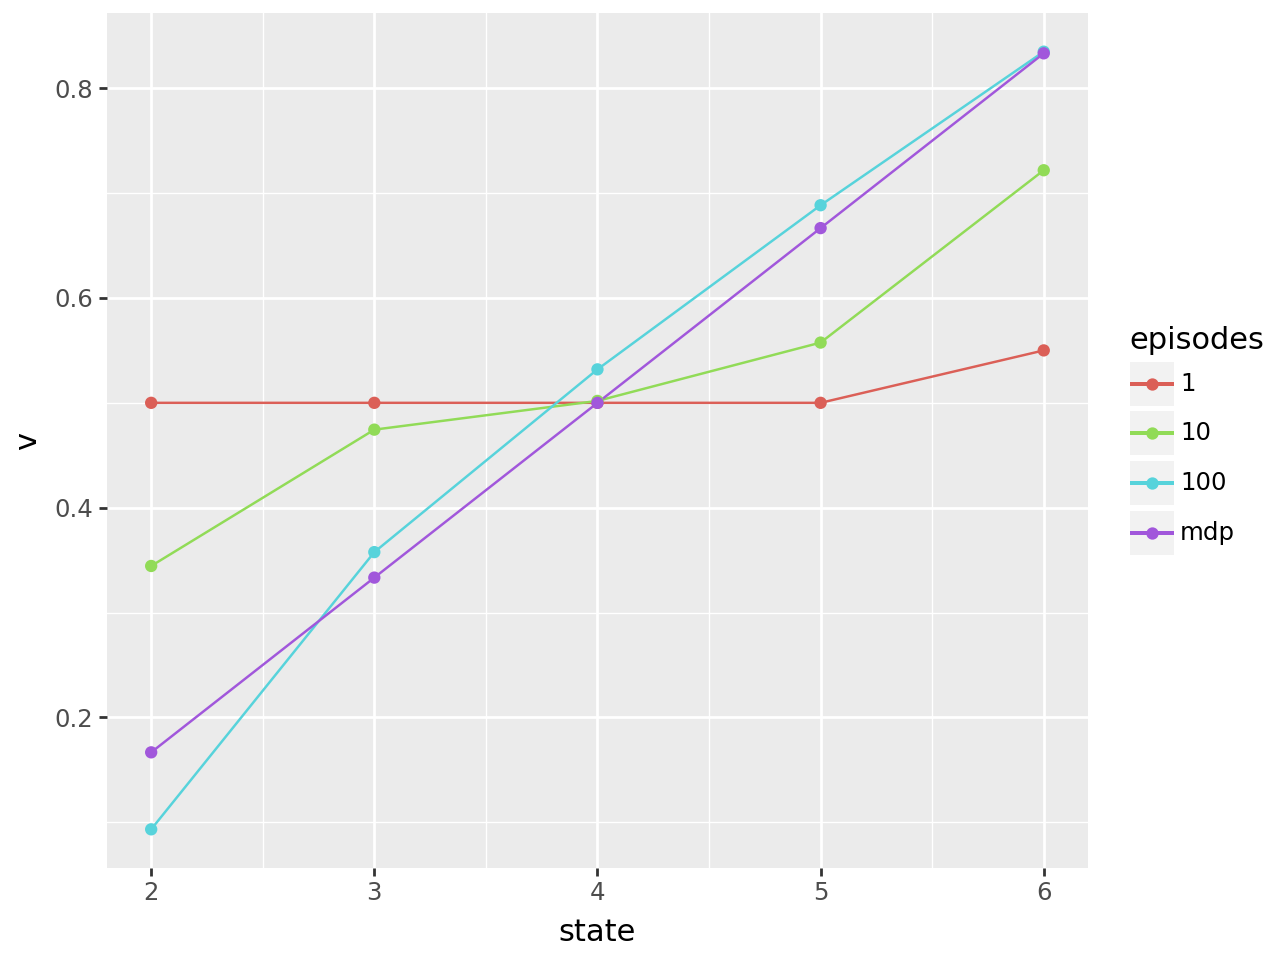


As can be seen, our estimates improve as TD(0) is used with more episodes.


In [9]:
#@title Solution

# --- 10 episodes ---
agent.set_state_value([str(i) for i in range(2, 7)], 0.5)
agent.set_state_value(["1", "7"], 0.0)
agent.policy_eval_td0(env, gamma=1.0, states=["4"], max_e=10, reset=False)
resTD0 = resTD0 >> bind_rows(agent.get_state_values() >> mutate(episodes=10))

# --- 100 episodes ---
agent.set_state_value([str(i) for i in range(2, 7)], 0.5)
agent.set_state_value(["1", "7"], 0.0)
agent.policy_eval_td0(env, gamma=1.0, states=["4"], max_e=100, reset=False)
resTD0 = resTD0 >> bind_rows(agent.get_state_values() >> mutate(episodes=100))

# --- add MDP values for comparison and filter interior states (2..6) ---
mdp_part = mdp.get_state_values() >> mutate(episodes="mdp")
resTD0 = resTD0 >> bind_rows(mdp_part) >> mutate(state=X.state.astype(int), episodes=X.episodes.astype(str)) >> filter_by((X.state > 1) & (X.state < 7))

# --- plot (plotnine) ---
pt = (ggplot(resTD0, aes(x="state", y="v", color="episodes"))
     + geom_line()
     + geom_point())
pt.show()

display(Markdown("""
As can be seen, our estimates improve as TD(0) is used with more episodes.
"""))

#### Q5

Run an MC prediction algorithm with 1, 10 and 100 episodes. Hint: you have to call `policy_eval_mc` instead of `policy_eval_td0`. Comment on your results.






Episode:
   s     a    r    g  n_s  old_v  new_v
0  4  left  0.0  0.0  2.0    0.5   0.25
1  3  left  0.0  0.0  2.0    0.5   0.25
2  2  left  0.0  0.0  2.0    0.5   0.25
Policy eval algorithm stopped at max iterations allowed: 1
Policy eval algorithm finished in 1 iterations.
  state     v  episodes
0     1  0.00         1
1     2  0.25         1
2     3  0.25         1
3     4  0.25         1
4     5  0.50         1
5     6  0.50         1
6     7  0.00         1
Policy eval algorithm stopped at max iterations allowed: 10
Policy eval algorithm finished in 10 iterations.
Policy eval algorithm stopped at max iterations allowed: 100
Policy eval algorithm finished in 100 iterations.


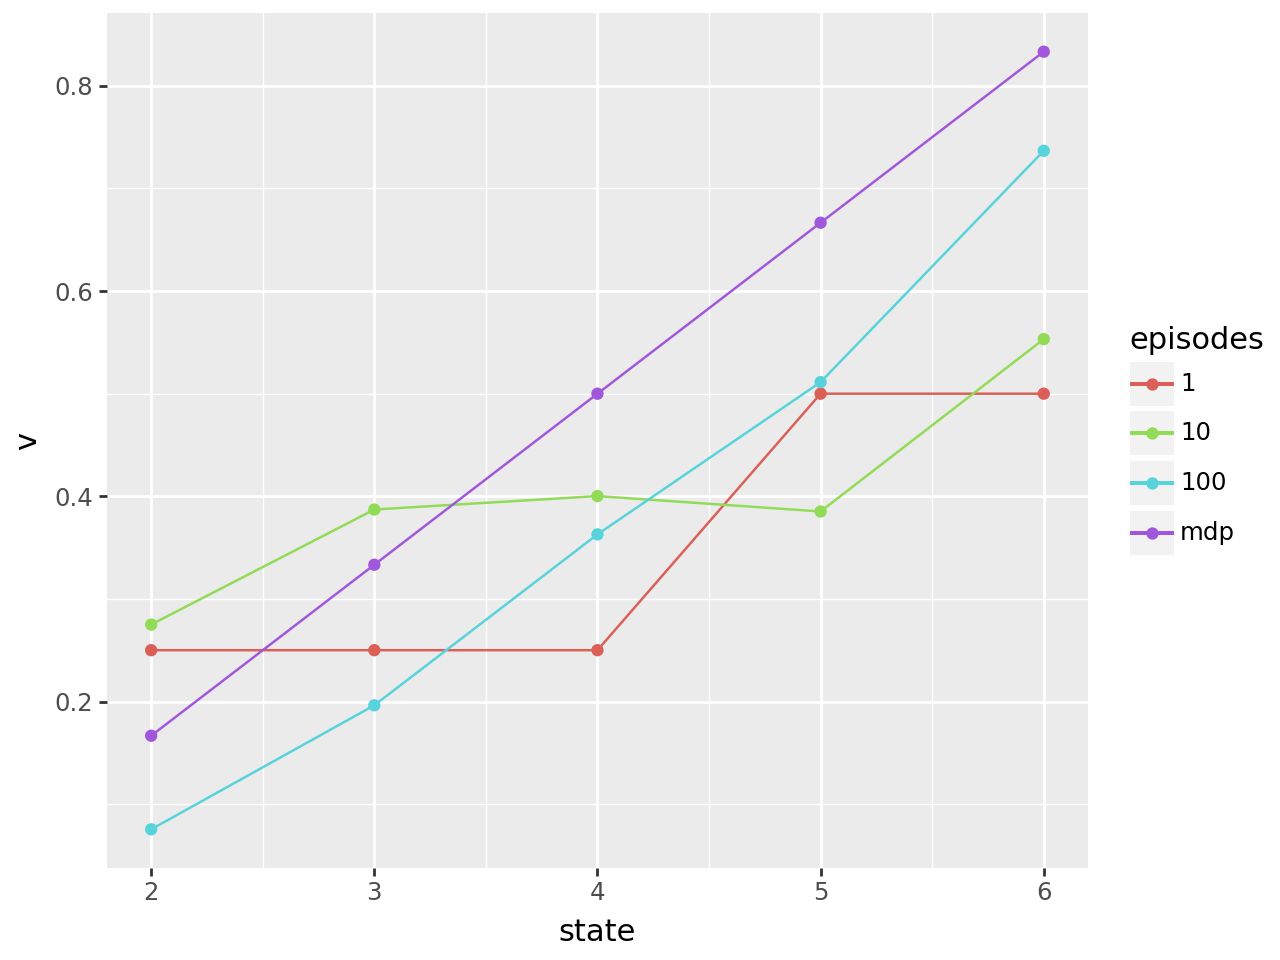


As can be seen, our estimates improve as MC is used with more episodes.
However, they are not as good as TD(0).


In [10]:
#@title Solution

np.random.seed(2947)

# convenience
states_mid = [str(i) for i in range(2, 7)]  # "2".."6"

# --- 1 episode ---
agent.set_state_value(states_mid, 0.5)
agent.set_state_value(["1", "7"], 0.0)
agent.set_state_ctr_value(1)  # used for incremential updates
agent.policy_eval_mc(env, gamma=1.0, states=["4"], min_ite=1, max_ite=1, reset=False, verbose=True)
resMC = agent.get_state_values() >> mutate(episodes=1)
print(resMC)

# --- 10 episodes ---
agent.set_state_value(states_mid, 0.5)
agent.set_state_value(["1", "7"], 0.0)
agent.set_state_ctr_value(1)
agent.policy_eval_mc(env, gamma=1.0, states=["4"], min_ite=10, max_ite=10, reset=False, verbose=False)
resMC = resMC >> bind_rows(agent.get_state_values() >> mutate(episodes=10))

# --- 100 episodes ---
agent.set_state_value(states_mid, 0.5)
agent.set_state_value(["1", "7"], 0.0)
agent.set_state_ctr_value(1)
agent.policy_eval_mc(env, gamma=1.0, states=["4"], min_ite=100, max_ite=100, reset=False)
resMC = resMC >> bind_rows(agent.get_state_values() >> mutate(episodes=100))

# add MDP baseline and keep interior states 2..6
resMC = resMC >> bind_rows(mdp_part) >> mutate(state=X.state.astype(int), episodes=X.episodes.astype(str)) >> filter_by((X.state > 1) & (X.state < 7))

# plot
pt = (ggplot(resMC, aes(x="state", y="v", color="episodes"))
     + geom_line()
     + geom_point())
pt.show()

display(Markdown("""
As can be seen, our estimates improve as MC is used with more episodes.
However, they are not as good as TD(0).
"""))

#### Q6

Let us join the results for TD(0) and MC and calculate the root mean square (RMS) error $$\sqrt{ \frac{1}{5}\sum_{s=2,\ldots 6}(V(s)-v_\pi(s))^2}.$$




In [11]:
resTD0 = resTD0 >> mutate(alg="TD0")
resMC = resMC >> mutate(alg="MC")
resMDP = (mdp.get_state_values() >> mutate(state=X.state.astype(int)))
resMDP = resMDP.rename(columns={"v": "vMDP"})
print(resMDP)

res = (resTD0
    >> bind_rows(resMC)
    >> filter_by(X.episodes != "mdp")
    >> left_join(resMDP, by='state')
    >> group_by(X.episodes, X.alg)
    >> summarize(rms=0.2 * ((X.v - X.vMDP) ** 2).sum())
)
res['rms'] = [np.sqrt(x) for x in res['rms']]
display(res)

   state      vMDP
0      1  0.000000
1      2  0.166648
2      3  0.333305
3      4  0.499972
4      5  0.666645
5      6  0.833323
6      7  0.000000


,alg,episodes,rms
0,MC,1,0.207484
1,TD0,1,0.222240
2,MC,10,0.190931
3,TD0,10,0.123180
4,MC,100,0.125976
5,TD0,100,0.038678


Which algorithm is best in estimating the state-values? Explain.

<details>
   <summary>Solution</summary>
   As can be seen, TD(0) performs best, since it does bootstrap. We can update our state-value estimates faster.
</details>

#### Q7

The results are dependent on the value of the step-size parameter. Let us estimate the state-values using TD(0) for $\alpha = 0.1, 0.2$ and 0.5 and plot the root mean square (RMS) error given the number of episodes:





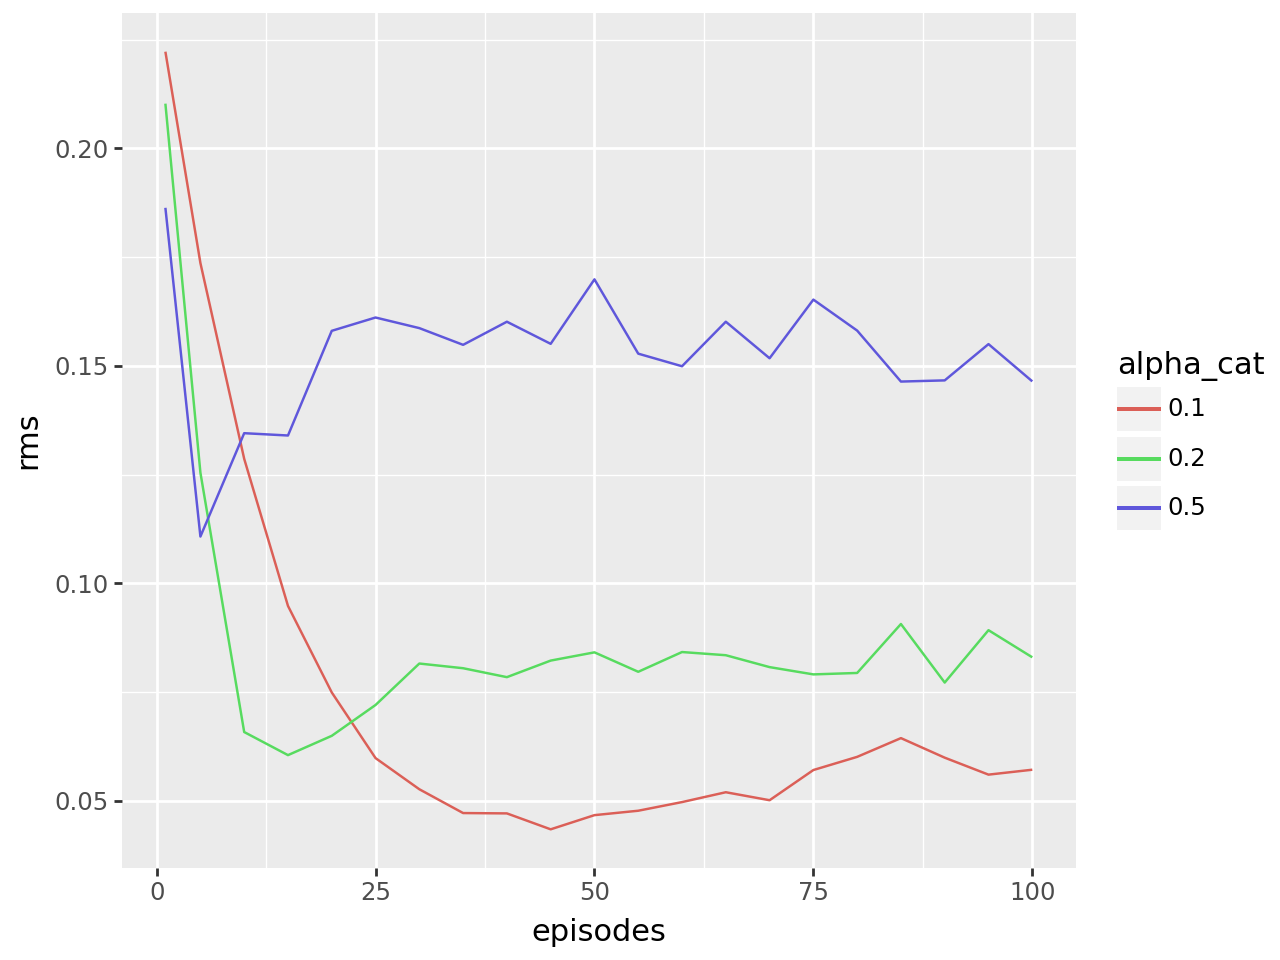

In [ ]:
random.seed(98)
np.random.seed(98)

states = [str(i) for i in range(2, 7)]  # "2".."6"
res = None

for run in range(1, 21):  # 1..20
    for alpha in (0.1, 0.2, 0.5):
        # reset values
        agent.set_state_value(states, 0.5)
        agent.set_state_value(["1", "7"], 0.0)

        e_old = 0  # number of episiodes
        for e in [1] + list(range(5, 101, 5)):  # 1, 5, 10, ...
            # run only the additional episodes each step
            agent.policy_eval_td0(env, gamma=1.0, states=["4"], max_e=e - e_old, alpha=alpha, reset=False)
            e_old = e

            step_df = agent.get_state_values() >> mutate(episodes=e, alpha=alpha, run=run)
            if res is None:
                res = step_df.copy()
            else:
                res = res >> bind_rows(step_df)
res = res >> mutate(state=X.state.astype(int))

res_plot = (res
            >> left_join(resMDP, by="state")
            >> group_by(X.episodes, X.alpha, X.run)
            >> summarize(rms=0.2 * ((X.v - X.vMDP) ** 2).sum())
)
res_plot['rms'] = [np.sqrt(x) for x in res_plot['rms']]
res_plot = (res_plot
            >> group_by(X.episodes, X.alpha)
            >> summarize(rms=X.rms.mean())
            >> mutate(alpha_cat=X.alpha.astype(str)))

pt = (ggplot(res_plot, aes(x="episodes", y="rms", color="alpha_cat"))
     + geom_line())
pt.show()


Explain the plot.

<details>
   <summary>Solution</summary>
   A step-size of 0.1 seems best if we have approximately. 20 episodes. If we can only estimate given a small number of episodes, then 0.2 seems better. Recall that the step-size relates to how much weight is put on the current estimate. Here we use a fixed step-size, but reducing the step-size when our estimate becomes better may be relevant in a stationary setting (as we are in here).
</details>